# Loan Eligibility Predictor 

In [17]:
# Dependencies
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from pathlib import Path
from utils import *
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve

### Data 

In [18]:
# Datasets 
train_data_path = Path("./dataset/train.csv") 
test_data_path = Path("./dataset/test.csv") 
train_data = pd.read_csv(train_data_path, encoding='utf-8', index_col='Loan_ID')
test_data = pd.read_csv(test_data_path, encoding='utf-8', index_col='Loan_ID')

train_data = train_data.drop('Credit_History', axis=1)
test_data = test_data.drop('Credit_History', axis=1)


### Exploratory Data Analysis

<Axes: title={'center': 'Distribution of Area Proportion'}, ylabel='None'>

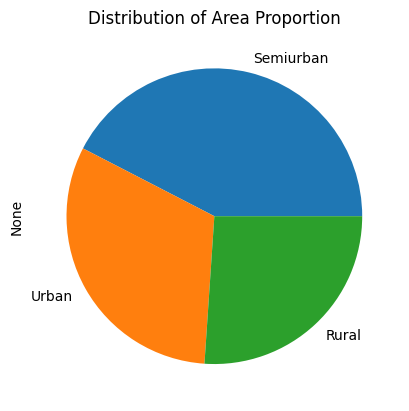

In [19]:
# Loan Approved Status dependence on Property Area
train_data[train_data['Loan_Status'] == 'Y']['Property_Area']\
    .value_counts(normalize=True)\
    .plot(kind='pie', title='Distribution of Area Proportion', ylabel='None') 

In [20]:
# Missing column in test_data
print(list(set(train_data.columns) - set(test_data.columns))[0])

Loan_Status


In [21]:
# DataFrame Shape Comparision
train_data.shape, train_data.dropna().shape

((614, 11), (523, 11))

In [22]:
df_NaN_Status(train_data)

Gender              	13/614
Married             	 3/614
Dependents          	15/614
Education           	 0/614
Self_Employed       	32/614
ApplicantIncome     	 0/614
CoapplicantIncome   	 0/614
LoanAmount          	22/614
Loan_Amount_Term    	14/614
Property_Area       	 0/614
Loan_Status         	 0/614


### Data Fetch and Engineering

In [23]:
X_train, y_train, X_test = get_train_test_data(train_data, test_data)

### Model

In [24]:
models = {
    'LogisticRegression': LogisticRegression(tol=0.0001, fit_intercept=True, verbose=False), 
    'RandomForrestClassifier': RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_leaf=4, min_samples_split=10, random_state=42), 
    'RandomForrestClassifierDefault': RandomForestClassifier(n_estimators=100, random_state=42, warm_start=True, class_weight='balanced') # Best performing
}
model = models['RandomForrestClassifierDefault']
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42,
                       warm_start=True)

### Hyperparameter tuning (for best model param selection)

In [25]:
hyperparam_grid = {
    'n_estimators'      : [100, 200, 300],
    'max_depth'         : [None, 10, 20, 30],
    'min_samples_split' : [2, 5, 10],
    'min_samples_leaf'  : [1, 2, 4]
}

# grid_search = GridSearchCV(RandomForestClassifier(random_state=42), hyperparam_grid, cv=5, scoring='f1')
# grid_search.fit(X_train, y_train)
# print("Best Parameters:", grid_search.best_params_)

In [26]:
# Cross Validation
cv_scores = cross_val_score(model, X_train, y_train, cv=5)
print("\nCross-validation scores:", cv_scores)
print("Average CV score:", cv_scores.mean())

# Feature Importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_ * 100
}).sort_values('importance', ascending=False)

print("\nFeature Importance: ")
print(feature_importance)


Cross-validation scores: [0.66666667 0.70731707 0.67479675 0.66666667 0.6557377 ]
Average CV score: 0.6742369718779154

Feature Importance: 
              feature  importance
5     ApplicantIncome   11.854129
10       Total_Income   11.773649
13  Loan_Income_Ratio   11.638819
14     Debt_to_Income   11.518991
11                EMI   10.386198
12                DTI   10.089917
7          LoanAmount    9.462708
6   CoapplicantIncome    8.011615
9       Property_Area    3.455718
2          Dependents    3.448534
8    Loan_Amount_Term    2.024008
3           Education    1.776695
1             Married    1.761257
0              Gender    1.504029
4       Self_Employed    1.293732


In [27]:
# F1 Score
y_pred = model.predict(X_train)
f1 = f1_score(y_true=y_train, y_pred=y_pred)

print("F1 Score: ", f1)

# Confusion matrix
cm = confusion_matrix(y_true=y_train, y_pred=y_pred)
print("\nConfustion Matrix: \t")
print(cm)

F1 Score:  1.0

Confustion Matrix: 	
[[192   0]
 [  0 422]]


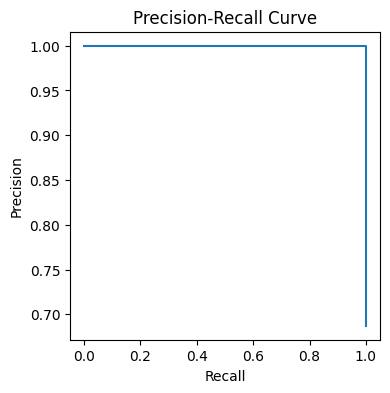

ROC-AUC Score: 1.0


In [28]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_train, model.predict_proba(X_train)[:, 1])
plt.figure(figsize=(4, 4))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# ROC-AUC
roc_auc = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])
print(f'ROC-AUC Score: {roc_auc}')

Loan_Approval_Status
Y    86.376022
N    13.623978
Name: proportion, dtype: float64


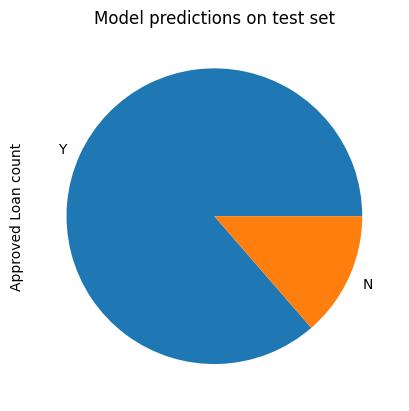

In [29]:
# Test predicitons with test dataset 
test_predictions = model.predict(X_test)
test_predictions_proba = model.predict_proba(X_test)

# Save predictions
predictions_df = pd.DataFrame({
    'Loan_ID': test_data.index,
    'Loan_Approval_Status': ['Y' if pred == 1 else 'N' for pred in test_predictions],
    'Confidence (%)': test_predictions_proba[:, 1]
})

print(predictions_df['Loan_Approval_Status'].value_counts(normalize=True) * 100)

predictions_pie = predictions_df['Loan_Approval_Status'].value_counts()\
    .plot(kind='pie', title='Model predictions on test set', ylabel="Approved Loan count")

### Test on sample data

In [30]:
# Example usage
sample_input = {
    'Gender'            : 'Male', 
    'Married'           : 'Yes', 
    'Dependents'        : '1',
    'Education'         : 'Graduate', 
    'Self_Employed'     : 'Yes',
    'ApplicantIncome'   : 50000, 
    'CoapplicantIncome' : 1000,
    'LoanAmount'        : 1000, 
    'Loan_Amount_Term'  : 60,
    'Property_Area'     : 'Rural'
}
status, confidence = predict_loan_eligibility(model, sample_input)
print(f"Loan Status: {status}, Confidence of approval: {confidence:.2%}")

Loan Status: Y, Confidence of approval: 69.00%


### Save the model 

In [31]:
save_model(model=model, fp="/Users/samarth/Programming/Loaner/model/loanPredictorModel.pkl")